In [123]:
import os
import sys


import numpy as np
from scipy.interpolate import griddata
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


NOTEBOOKS_DIR: str = os.path.abspath("")
PARENT_DIR: str = os.path.dirname(NOTEBOOKS_DIR)

DATA_DIR: str = os.path.join(PARENT_DIR, "data")

sys.path.append(PARENT_DIR)

from utils.data_reader import read_contour_file, multithreading_reader_dat_file
from utils.preprocess import apply_contour

In [124]:
contour_df = (
    read_contour_file(
        file_path="/home/viniciusparede/repositories/personal/btg-challenge/data/PSATCMG_CAMARGOS.bln"
    ),
)[0]
forecast_df = multithreading_reader_dat_file(folder_path=DATA_DIR)

In [125]:
df = apply_contour(contour_df, forecast_df)

In [126]:
df.iloc[100]

lat_referencia     -44.569716
long_referencia    -22.239244
lat_aproximacao         -44.6
long_aproximacao        -22.2
data_value               18.0
distance              0.04957
data_previsao        10/12/21
Name: 10, dtype: object

In [127]:
df = df.loc[:, ["lat_aproximacao", "long_aproximacao", "data_value", "data_previsao"]].copy()
df.head()

,lat_aproximacao,long_aproximacao,data_value,data_previsao
0,-44.6,-22.2,18.0,10/12/21
0,-44.6,-22.2,5.5,05/12/21
0,-44.6,-22.2,7.2,03/12/21
0,-44.6,-22.2,1.9,04/12/21
0,-44.6,-22.2,24.6,09/12/21


In [128]:
df.drop_duplicates(
    subset=["lat_aproximacao", "long_aproximacao", "data_value"], inplace=True
)
df.sort_values(by=["lat_aproximacao", "long_aproximacao", "data_previsao"], inplace=True)
df.reset_index(drop=True, inplace=True)

df


,lat_aproximacao,long_aproximacao,data_value,data_previsao
0,-44.6,-22.2,1.0,02/12/21
1,-44.6,-22.2,7.2,03/12/21
2,-44.6,-22.2,1.9,04/12/21
3,-44.6,-22.2,5.5,05/12/21
4,-44.6,-22.2,11.9,06/12/21
...,...,...,...,...
75,-43.8,-21.4,4.7,07/12/21
76,-43.8,-21.4,19.9,08/12/21
77,-43.8,-21.4,4.3,09/12/21
78,-43.8,-21.4,33.9,10/12/21


In [129]:
polygonal_order = [
    (-44.6, -22.2),
    (-44.6, -21.8),
    (-44.6, -21.4),
    (-44.2, -21.4),
    (-43.8, -21.4),
    (-43.8, -21.8),
    (-44.2, -21.8),
    (-44.2, -22.2),
]

# Criar uma coluna que represente a ordem específica do polígono
df["ordem"] = df.apply(
    lambda row: polygonal_order.index(
        (row["lat_aproximacao"], row["long_aproximacao"])
    ),
    axis=1,
)

# Ordenar o DataFrame pela coluna 'ordem' e, em seguida, remover a coluna 'ordem'
df_ordenado = df.sort_values(by="ordem").drop("ordem", axis=1)

# df assume a ordenação
df = df_ordenado.copy()

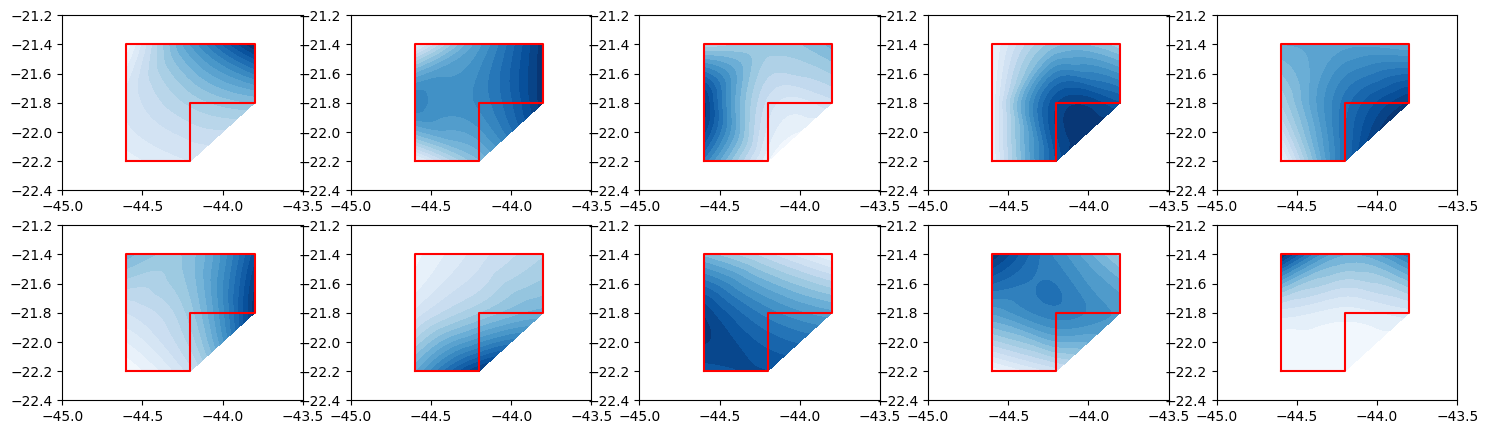

In [130]:
# Criar uma figura com 5 colunas e 1 linha
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 5))
dates = df["data_previsao"].sort_values().unique()
polygon = [
    (-44.6, -22.2),
    (-44.6, -21.8),
    (-44.6, -21.4),
    (-44.2, -21.4),
    (-43.8, -21.4),
    (-43.8, -21.8),
    (-44.2, -21.8),
    (-44.2, -22.2),
    (-44.6, -22.2),
]

z = 0
result = list()
for i in range(2):
    for j in range(5):
        data = list(
            df.loc[df["data_previsao"] == dates[z]]
            .copy()
            .itertuples(index=False, name=None)
        )

        # latitude, longitude e valores de precipitação
        latitude = [d[0] for d in data]
        longitude = [d[1] for d in data]
        precipitacao = [d[2] for d in data]

        # Definindo Intervalos
        latitude_linspace = np.linspace(min(latitude), max(latitude), 1000)
        longitude_linspace = np.linspace(min(longitude), max(longitude), 1000)

        # Definir a mesgrid para a interpolação
        grid_x, grid_y = np.meshgrid(
            latitude_linspace,
            longitude_linspace,
        )

        # Interpolação
        grid_precipitacao = griddata(
            (latitude, longitude), precipitacao, (grid_x, grid_y), method="cubic"
        )

        # Plot dos resultados
        axs[i][j].contourf(grid_x, grid_y, grid_precipitacao, levels=20, cmap="Blues")
        # axs[i][j].colorbar(label="Precipitação [mm]")

        axs[i][j].plot([p[0] for p in polygon], [p[1] for p in polygon], color="red")

        # Ajustar os limites dos eixos
        axs[i][j].set_xlim(-45, -43.5)
        axs[i][j].set_ylim(-22.4, -21.2)

        # Calcular a integral da precipitação interpolada
        integral_precipitacao = cumulative_trapezoid(grid_precipitacao, x=grid_x)

        # Criar uma máscara booleana para identificar valores não NaN
        mascara = ~np.isnan(integral_precipitacao)

        # Aplicar a máscara para selecionar elementos não NaN
        vetor_sem_nan = integral_precipitacao[mascara]

        result.append(np.max(vetor_sem_nan))

        z += 1

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/viniciusparede/repositories/personal/btg-challenge/data/btg.png'

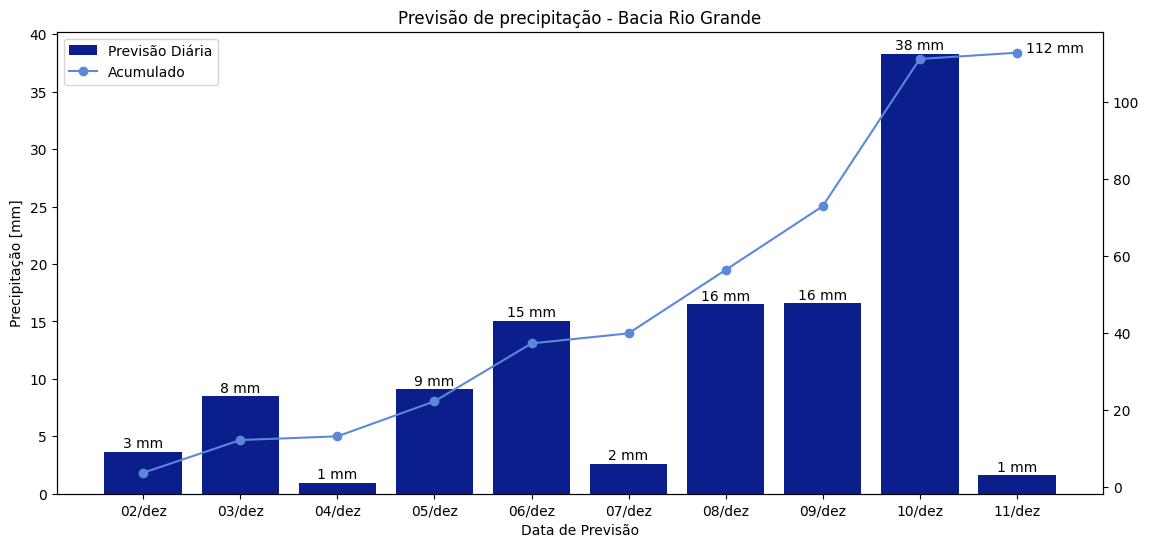

In [131]:
# Calculando a linha acumulada
linha_acumulada = np.cumsum(result)

# Criar o gráfico
fig, ax1 = plt.subplots(figsize=(13.5, 6))


labels = [
    "02/dez",
    "03/dez",
    "04/dez",
    "05/dez",
    "06/dez",
    "07/dez",
    "08/dez",
    "09/dez",
    "10/dez",
    "11/dez",
]

# Gráfico de barras
bars = ax1.bar(labels, result, color="#0A1E8C", label="Previsão Diária")

ax1.set_xlabel("Data de Previsão")
ax1.set_ylabel("Precipitação [mm]")
ax1.tick_params(axis="y")

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    yval = bar.get_height()

    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval + 0.7,
        f"{int(round(yval, 1))} mm",
        va="center",
        ha="center",
    )


# Segundo eixo y para a linha acumulada
ax2 = ax1.twinx()
ax2.plot(
    labels,
    linha_acumulada,
    color="#5C88DA",
    marker="o",
    label="Acumulado",
)

offset = 0.1
ax2.tick_params(axis="y")
ax2.text(
    offset + bar.get_x() + bar.get_width() / 2.0,
    linha_acumulada[-1],
    str(int(linha_acumulada[-1])) + " mm",
)

# Adicionar legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")


plt.title("Previsão de precipitação - Bacia Rio Grande")


# Coordenadas para posicionar a imagem no centro
img_x = 615
img_y = 475

# BTG
img = mpimg.imread(os.path.join(DATA_DIR, "btg.png"))
imagebox = plt.figimage(img, xo=img_x, yo=img_y, alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "result.png"))
plt.show()